In [25]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [26]:
mg_noIBX_abs = pd.read_csv('/Users/turbold/Documents/CUSP/ADS/IBXRidership/mg_noIBX_abs.csv', index_col=0).fillna(0)
mg_noIBX_norm = pd.read_csv('/Users/turbold/Documents/CUSP/ADS/IBXRidership/mg_noIBX_norm.csv', index_col=0).fillna(0)
mg_noIBX_log = pd.read_csv('/Users/turbold/Documents/CUSP/ADS/IBXRidership/mg_noIBX_log.csv', index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0)

In [27]:
cols_offpeak = ['cs_noibx_offpeak','lotarea', 'bldgarea',
                'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
                'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
                'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
                'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
                'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
                'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
                'vacant_homes_num', 'Bus_Stops']

cols_peak = ['cs_noibx_peak','lotarea', 'bldgarea',
             'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
             'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
             'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
             'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
             'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
             'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
             'vacant_homes_num', 'Bus_Stops']
             
mg_noIBX_abs.columns

Index(['complex_id', 'Stop Name', 'Complex_id', 'exits_weekday_evening',
       'entries_weekday_evening', 'exits_weekday_morning',
       'entries_weekday_morning', 'exits_weekday_overnight',
       'entries_weekday_overnight', 'exits_weekend_evening',
       'entries_weekend_evening', 'exits_weekend_morning',
       'entries_weekend_morning', 'exits_weekend_overnight',
       'entries_weekend_overnight', 'cs_ibx_peak', 'cs_ibx_offpeak',
       'cs_noibx_peak', 'cs_noibx_offpeak', 'VoroID', 'lotarea', 'bldgarea',
       'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
       'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
       'vacant_homes_num', 'Bus_Stops', 'geometry', 

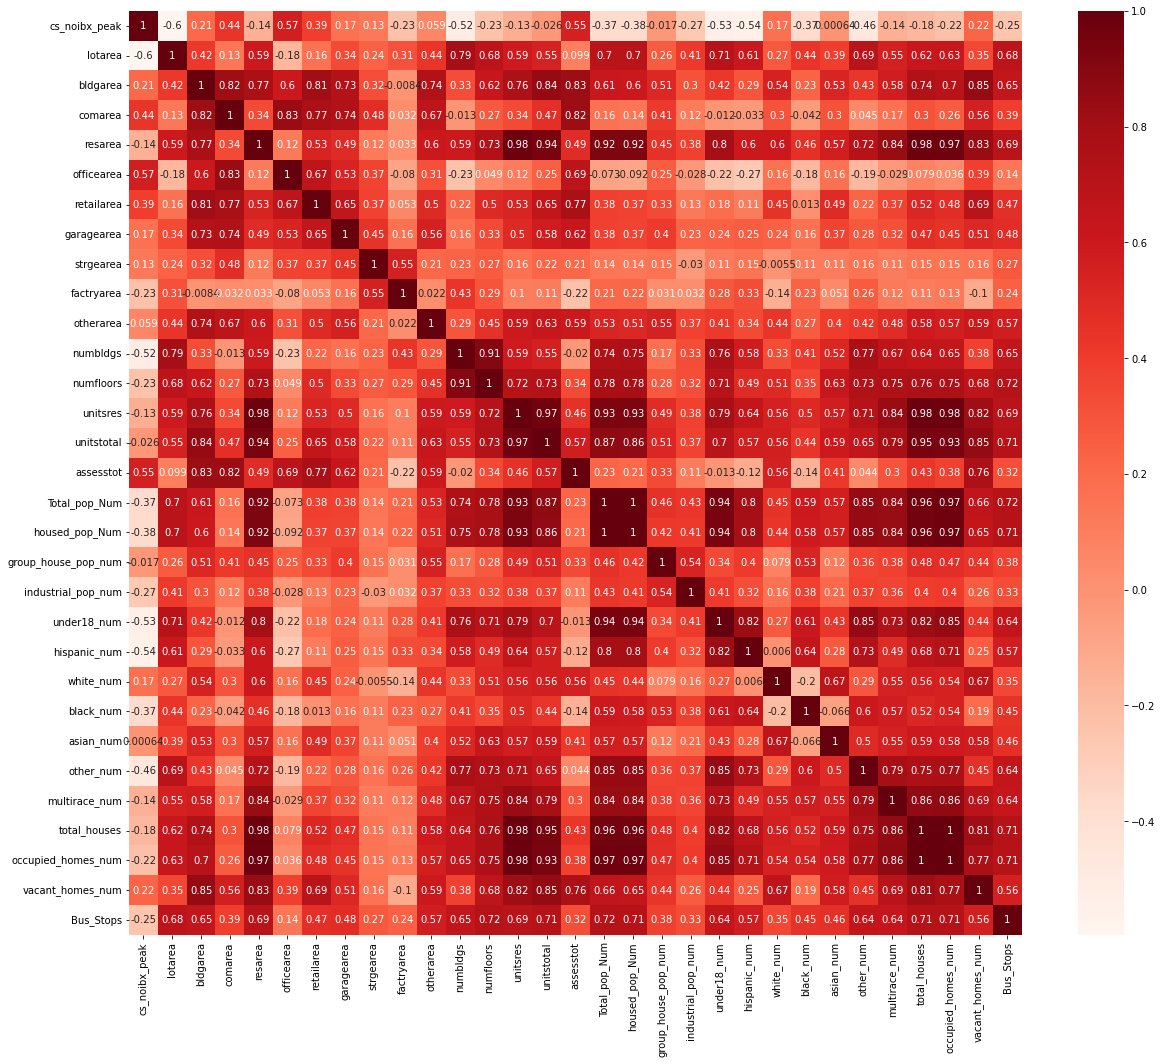

In [130]:
#Using Pearson Correlation
plt.figure(figsize=(20,17))
cor = mg_noIBX_log[cols_peak].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('/Users/turbold/Documents/CUSP/ADS/IBX_cov_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

In [210]:
turnstile_data =['exits_weekday_evening',
       'entries_weekday_evening', 'exits_weekday_morning',
       'entries_weekday_morning', 'exits_weekday_overnight',
       'entries_weekday_overnight', 'exits_weekend_evening',
       'entries_weekend_evening', 'exits_weekend_morning',
       'entries_weekend_morning', 'exits_weekend_overnight',
       'entries_weekend_overnight']

peak_nonpeak = ['cs_noibx_peak', 'cs_noibx_offpeak']

#Simple OLS on all variables
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              model=sm.OLS(mg_noIBX_abs[commute_period],mg_noIBX_abs[cols_offpeak]).fit()  
              print('{}:'.format(commute_period), model.rsquared)
       elif 'overnight' in commute_period:
              model=sm.OLS(mg_noIBX_abs[commute_period],mg_noIBX_abs[cols_offpeak]).fit()  
              print('{}:'.format(commute_period),model.rsquared)
       else:
              model=sm.OLS(mg_noIBX_abs[commute_period],mg_noIBX_abs[cols_peak]).fit() 
              print('{}:'.format(commute_period), model.rsquared)

exits_weekday_evening: 0.6391422517285492
entries_weekday_evening: 0.7161547111591543
exits_weekday_morning: 0.7226837247439848
entries_weekday_morning: 0.6943501693880192
exits_weekday_overnight: 0.6399153086115277
entries_weekday_overnight: 0.5533396681243157
exits_weekend_evening: 0.6281433609137657
entries_weekend_evening: 0.6511150656848386
exits_weekend_morning: 0.6641448601470219
entries_weekend_morning: 0.6707783367467508
exits_weekend_overnight: 0.6134179659446968
entries_weekend_overnight: 0.5299385194004055


In [30]:
#LassoCV scores on absolute values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_abs[cols_peak], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs[cols_peak], mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))


exits_weekday_evening: 0.22494914923277776
exits_weekday_evening Selected Features: ['assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num'
 'other_num']
entries_weekday_evening: 0.4429496382558601
entries_weekday_evening Selected Features: ['lotarea' 'assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num']
exits_weekday_morning: 0.4579390796814051
exits_weekday_morning Selected Features: ['lotarea' 'assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num']
entries_weekday_morning: 0.21015790016620584
entries_weekday_morning Selected Features: ['assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num'
 'other_num']
exits_weekday_overnight: 0.22447645624729673
exits_weekday_overnight Selected Features: ['lotarea' 'bldgarea' 'assesstot' 'occupied_homes_num' 'total_houses']
entries_weekday_overnight: 0.2230433109081923
entries_weekday_overnight Selected Features: ['assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num'
 'other_num']
exits_weekend_eveni

In [174]:
lassocv_log_rsquare = {}


#LassoCV scores on log values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           r_square = Lasso_model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), r_square)
           lassocv_log_rsquare[commute_period]= r_square
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           pos_index = len(importance[importance != 0])
           idx_third = importance.argsort()[-pos_index]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()
           name_features = list(np.array(cols_offpeak)[idx_features])
           feature_coef =-np.sort(-importance)
           feature_coef = list(feature_coef[feature_coef != 0])
           #offpeak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['features','coef'])
           print('{} Selected Features: {}'.format(commute_period, [name_features, feature_coef]))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           r_square = Lasso_model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), r_square)
           lassocv_log_rsquare[commute_period]= r_square
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           pos_index = len(importance[importance != 0])
           idx_third = importance.argsort()[-pos_index]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()
           name_features = list(np.array(cols_offpeak)[idx_features])
           feature_coef =-np.sort(-importance)
           feature_coef = list(feature_coef[feature_coef != 0])
           print('{} Selected Features: {}'.format(commute_period, [name_features, feature_coef]))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period])
           r_square = Lasso_model.score(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), r_square)
           lassocv_log_rsquare[commute_period]= r_square
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           pos_index = len(importance[importance != 0])
           idx_third = importance.argsort()[-pos_index]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()
           name_features = list(np.array(cols_peak)[idx_features])
           feature_coef =-np.sort(-importance)
           feature_coef = list(feature_coef[feature_coef != 0])
           #peak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['features','coef'])
           print('{} Selected Features: {}'.format(commute_period, [name_features, feature_coef]))

exits_weekday_evening: 0.4182592365794702
exits_weekday_evening Selected Features: [['resarea', 'occupied_homes_num', 'unitstotal', 'numfloors', 'numbldgs', 'lotarea', 'Bus_Stops', 'assesstot', 'retailarea', 'comarea', 'asian_num', 'white_num', 'other_num', 'hispanic_num', 'under18_num', 'officearea', 'strgearea', 'black_num', 'garagearea', 'group_house_pop_num', 'multirace_num', 'otherarea', 'vacant_homes_num', 'factryarea', 'industrial_pop_num', 'Total_pop_Num', 'unitsres', 'total_houses', 'bldgarea', 'housed_pop_Num', 'cs_noibx_peak'], [0.8136656975932665, 0.5331637066750393, 0.43916572698846024, 0.3735078607381311, 0.36441911312144365, 0.3348061309576077, 0.3285994913910156, 0.32687942503542183, 0.3062691046416016, 0.20023852698915826, 0.18010821280499945, 0.16652609775161567, 0.0931261091280103, 0.09134299865126273, 0.05116071788294811, 0.04658772802414629, 0.03980680531832084, 0.020155905772885827, 0.01984815601284925, 0.012937119015498492, 0.012380866554518819, 0.008789146767596

In [107]:
Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_peak], mg_noIBX_log['entries_weekday_evening'])
r_square = Lasso_model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log['entries_weekday_evening'])
 #print r-square for commute period
print('{}:'.format('entries_weekday_evening'), r_square)
lassocv_log_rsquare[commute_period]= r_square
#print top features in order of importance
importance = np.abs(Lasso_model.coef_)
idx_third = importance.argsort()[-10]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()[:10]
name_features = np.array(cols_offpeak)[idx_features]
print('{} Selected Features: {}'.format(commute_period, name_features), )
idx_features

entries_weekday_evening: 0.6411254075812248
entries_weekend_overnight Selected Features: ['assesstot' 'lotarea' 'Bus_Stops' 'retailarea' 'numbldgs' 'asian_num'
 'other_num' 'garagearea' 'white_num' 'strgearea']


array([15,  1, 30,  6, 11, 24, 25,  7, 22,  8])

In [121]:
lasso_features_e_wd_ev =-np.sort(-importance)
list(lasso_features_e_wd_ev[lasso_features_e_wd_ev != 0])

[0.534982451263201,
 0.419252350907043,
 0.30383635116230334,
 0.2669654223152617,
 0.26518394760994124,
 0.22017837019989006,
 0.17938715239091108,
 0.17085424589860587,
 0.08192559304136972,
 0.06101295269919042,
 0.059866828404115,
 0.04101023571481973,
 0.02248411644321878,
 0.014550924979033862,
 0.006444665326775094,
 0.0056867683289791296,
 0.005638701878802478]

In [189]:
lassocv_log_rsquare

{'exits_weekday_evening': 0.4182592365794702,
 'entries_weekday_evening': 0.6411254075812248,
 'exits_weekday_morning': 0.5843682472150777,
 'entries_weekday_morning': 0.4860567610200055,
 'exits_weekday_overnight': 0.4212875802358229,
 'entries_weekday_overnight': 0.49040047992641966,
 'exits_weekend_evening': 0.5113027873343989,
 'entries_weekend_evening': 0.5953922542153972,
 'exits_weekend_morning': 0.5513883837582688,
 'entries_weekend_morning': 0.5486323614382993,
 'exits_weekend_overnight': 0.4431952178609574,
 'entries_weekend_overnight': 0.594797742593068}

In [11]:

#LassoCV scores on norm values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period]))
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period]))
           
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_norm[cols_peak], mg_noIBX_norm[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_norm[cols_peak], mg_noIBX_norm[commute_period]))
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))

exits_weekday_evening: 0.16583954241927457
exits_weekday_evening Selected Features: ['assesstot' 'Bus_Stops' 'bldgarea' 'occupied_homes_num' 'total_houses']
entries_weekday_evening: 0.37390638563580814
entries_weekday_evening Selected Features: ['assesstot' 'Bus_Stops' 'bldgarea' 'occupied_homes_num' 'total_houses']
exits_weekday_morning: 0.36744229724848576
exits_weekday_morning Selected Features: ['assesstot' 'Bus_Stops' 'bldgarea' 'occupied_homes_num' 'total_houses']
entries_weekday_morning: 0.14820306404768646
entries_weekday_morning Selected Features: ['Bus_Stops' 'assesstot' 'bldgarea' 'occupied_homes_num' 'total_houses']
exits_weekday_overnight: 0.12857621808988406
exits_weekday_overnight Selected Features: ['assesstot' 'Bus_Stops' 'bldgarea' 'occupied_homes_num' 'total_houses']
entries_weekday_overnight: 0.1906969334308395
entries_weekday_overnight Selected Features: ['Bus_Stops' 'assesstot' 'bldgarea' 'occupied_homes_num' 'total_houses']
exits_weekend_evening: 0.20595463215445

In [14]:
# make a pipeline - specify the model
pipe = Pipeline([("scale", preprocessing.StandardScaler()),
                 ("reduce_dims", PCA()),
                 ("lasso", Lasso())
                ])

param_grid = dict(reduce_dims__n_components = np.arange(1,31,1),
                  lasso__alpha = 2.0**(np.arange(-10, 10, 1)))

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True,n_jobs=-1, cv=5)



#Loop through different independent variables                  
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              grid.fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       elif 'overnight' in commute_period:
              grid.fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       else:
              grid.fit(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
exits_weekday_evening best R-score: 0.2991562556877284
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=15)),
                ('lasso', Lasso(alpha=0.00390625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
entries_weekday_evening best R-score: 0.5518947962083067
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=17)),
                ('lasso', Lasso(alpha=0.0078125))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
exits_weekday_morning best R-score: 0.4775006666129542
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=15)),
                ('lasso', Lasso(alpha=0.00390625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
entries_weekday_morning best R-score: 0.3092764943964072
Pipeline(steps=[('scale', StandardScaler()),
                (

In [16]:
grid.best_params_
mg_noIBX_abs.shape

(424, 55)

In [20]:
#setting current so can re run everything easily (raw, absolute, log)
current = mg_noIBX_log

cols_housing = ['unitsres','unitstotal','total_houses', 'occupied_homes_num',
       'vacant_homes_num','resarea']


cols_dems = ['Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num']

#composite score for housing 
x = StandardScaler().fit_transform(current[cols_housing])

pca_housing = PCA(n_components=1)
housing_composite = pca_housing.fit_transform(x)

#and demographics 
x = StandardScaler().fit_transform(current[cols_dems])

pca_demo = PCA(n_components=1)
demo_composite = pca_demo.fit_transform(x)

cols_short = ['lotarea', 'bldgarea', 'comarea', 'officearea', 'retailarea',
       'garagearea', 'strgearea', 'factryarea', 'otherarea', 'numbldgs',
       'numfloors', 'assesstot', 'Bus_Stops']

#cols for features except for centrality score --> fitting all in 
cols = ['lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea',
       'garagearea', 'strgearea', 'factryarea', 'otherarea', 'numbldgs',
       'numfloors', 'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
       'vacant_homes_num', 'Bus_Stops']

#diff feature columns time depending 
cols_peak = cols + ['cs_noibx_peak']
cols_offpeak = cols + ['cs_noibx_offpeak']

#for use with PCA - only adding non PCA values, column selection
cols_peak = cols_short + ['cs_noibx_peak'] + ['housing_index'] + ['pop_index']
cols_offpeak = cols_short + ['cs_noibx_offpeak'] + ['housing_index'] + ['pop_index']

#merge with current
current = current.assign(housing_index=housing_composite)
current = current.assign(pop_index=demo_composite)

In [24]:
current.to_csv('mg_noIBX_log_composite.csv')

In [105]:
#LassoCV scores on log values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(current[cols_offpeak], current[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(current[cols_offpeak], current[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(current[cols_offpeak], current[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(current[cols_offpeak], current[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(current[cols_peak], current[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(current[cols_peak], current[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))

exits_weekday_evening: 0.4182592365794702
exits_weekday_evening Selected Features: ['resarea' 'occupied_homes_num' 'unitstotal' 'numfloors' 'numbldgs']
entries_weekday_evening: 0.6411254075812248
entries_weekday_evening Selected Features: ['assesstot' 'lotarea' 'Bus_Stops' 'retailarea' 'numbldgs']
exits_weekday_morning: 0.5843682472150777
exits_weekday_morning Selected Features: ['assesstot' 'lotarea' 'Bus_Stops' 'retailarea' 'unitstotal']
entries_weekday_morning: 0.4860567610200055
entries_weekday_morning Selected Features: ['resarea' 'unitstotal' 'numbldgs' 'housed_pop_Num' 'retailarea']
exits_weekday_overnight: 0.4212875802358229
exits_weekday_overnight Selected Features: ['resarea' 'numfloors' 'numbldgs' 'lotarea' 'Bus_Stops']
entries_weekday_overnight: 0.49040047992641966
entries_weekday_overnight Selected Features: ['assesstot' 'retailarea' 'white_num' 'Bus_Stops' 'lotarea']
exits_weekend_evening: 0.5113027873343989
exits_weekend_evening Selected Features: ['resarea' 'assesstot' 

In [23]:
# make a pipeline - specify the model
pipe = Pipeline([("scale", preprocessing.StandardScaler()),
                 ("reduce_dims", PCA()),
                 ("lasso", Lasso())
                ])

param_grid = dict(reduce_dims__n_components = np.arange(1,31,1),
                  lasso__alpha = 2.0**(np.arange(-10, 10, 1)))

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True,n_jobs=-1, cv=5)



#Loop through different independent variables                  
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              grid.fit(current[cols_offpeak], current[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       elif 'overnight' in commute_period:
              grid.fit(current[cols_offpeak], current[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       else:
              grid.fit(current[cols_peak], current[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
exits_weekday_evening best R-score: 0.24675616616824714
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=6)),
                ('lasso', Lasso(alpha=0.0009765625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
entries_weekday_evening best R-score: 0.5495639636029281
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=10)),
                ('lasso', Lasso(alpha=0.015625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
exits_weekday_morning best R-score: 0.47461741134652835
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=8)),
                ('lasso', Lasso(alpha=0.03125))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
entries_weekday_morning best R-score: 0.19852701114788357
Pipeline(steps=[('scale', StandardScaler()),
                ('

In [96]:
# make a pipeline - specify the model
pipe = Pipeline([ ("lasso", Lasso(max_iter=10000))
                ])

param_grid = dict(lasso__alpha = 2.0**(np.arange(-10, 10, 1)))

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True,n_jobs=-1, cv=5)



#Loop through different independent variables                  
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              grid.fit(current[cols_offpeak], current[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       elif 'overnight' in commute_period:
              grid.fit(current[cols_offpeak], current[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       else:
              grid.fit(current[cols_peak], current[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
exits_weekday_evening best R-score: 0.22401233147521965
Pipeline(steps=[('lasso', Lasso(alpha=0.015625, max_iter=10000))])
Fitting 5 folds for each of 20 candidates, totalling 100 fits
entries_weekday_evening best R-score: 0.5074338668198128
Pipeline(steps=[('lasso', Lasso(alpha=0.015625, max_iter=10000))])
Fitting 5 folds for each of 20 candidates, totalling 100 fits
exits_weekday_morning best R-score: 0.41941591522241806
Pipeline(steps=[('lasso', Lasso(alpha=0.015625, max_iter=10000))])
Fitting 5 folds for each of 20 candidates, totalling 100 fits
entries_weekday_morning best R-score: 0.2674830845054142
Pipeline(steps=[('lasso', Lasso(alpha=0.0009765625, max_iter=10000))])
Fitting 5 folds for each of 20 candidates, totalling 100 fits
exits_weekday_overnight best R-score: 0.162902751785393
Pipeline(steps=[('lasso', Lasso(alpha=0.00390625, max_iter=10000))])
Fitting 5 folds for each of 20 candidates, totalling 100 fits
entri

In [97]:
# make a pipeline - specify the model
pipe = Pipeline([ ("lasso", Lasso(max_iter=10000))
                ])

param_grid = dict(lasso__alpha = 2.0**(np.arange(-10, 10, 1)))

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True,n_jobs=-1, cv=5)

grid.fit(current[cols_offpeak], current[commute_period])
#print('{} best R-score:'.format(commute_period), grid.best_score_)
print(grid.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Pipeline(steps=[('lasso', Lasso(alpha=0.015625, max_iter=10000))])


In [185]:
Lasso_model = LassoCV(cv=5, random_state=2012, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_peak], mg_noIBX_log['entries_weekday_evening'])
r_square = Lasso_model.score(mg_noIBX_log[cols_peak], mg_noIBX_log['entries_weekday_evening'])
#print r-square for commute period
print('entries_weekday_evening', r_square)
lassocv_log_rsquare['entries_weekday_evening']= r_square
#print top features in order of importance
importance = np.abs(Lasso_model.coef_)
pos_index = len(importance[importance != 0])
idx_third = importance.argsort()[-pos_index]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()
name_features = list(np.array(cols_peak)[idx_features])
feature_coef =-np.sort(-importance)
feature_coef = list(feature_coef[feature_coef != 0])
peak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['Features','Coefficient'])
print('{} Selected Features: {}'.format(commute_period, [name_features, feature_coef]))

entries_weekday_evening 0.6411254075812248
entries_weekend_overnight Selected Features: [['assesstot', 'lotarea', 'Bus_Stops', 'retailarea', 'numbldgs', 'asian_num', 'other_num', 'garagearea', 'white_num', 'strgearea', 'hispanic_num', 'unitstotal', 'otherarea', 'group_house_pop_num', 'black_num', 'comarea', 'total_houses', 'occupied_homes_num', 'multirace_num', 'under18_num', 'Total_pop_Num', 'housed_pop_Num', 'bldgarea', 'vacant_homes_num', 'unitsres', 'numfloors', 'factryarea', 'officearea', 'resarea', 'industrial_pop_num', 'cs_noibx_peak'], [0.4298298712790913, 0.3758742146106998, 0.27457462666355803, 0.2713938249242947, 0.21850766363008406, 0.11237211504185707, 0.06916769249793071, 0.05792665713140566, 0.04215596887851251, 0.024385125417102856, 0.021384092391507518, 0.013089713915168909, 0.011792886360837756, 0.01042494202843908]]


In [186]:
feature_coef

[0.4298298712790913,
 0.3758742146106998,
 0.27457462666355803,
 0.2713938249242947,
 0.21850766363008406,
 0.11237211504185707,
 0.06916769249793071,
 0.05792665713140566,
 0.04215596887851251,
 0.024385125417102856,
 0.021384092391507518,
 0.013089713915168909,
 0.011792886360837756,
 0.01042494202843908]

In [206]:
import altair as alt
import selenium

alt.Chart(peak).mark_bar().encode(
    y=alt.Y('Features:N', sort='-x'),
    x='Coefficient'
).properties(
    title='Important Features of Lasso CV Weekday Evening Entries'
)#.save('/Users/turbold/Documents/CUSP/ADS/IBXRidership/Data Vis/peak_chart.png', scale_factor=2.0)


alt.Chart(...)

In [163]:
Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log['entries_weekend_evening'])
#print top features in order of importance
importance = np.abs(Lasso_model.coef_)
pos_index = len(importance[importance != 0])
idx_third = importance.argsort()[-pos_index]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()
name_features = list(np.array(cols_offpeak)[idx_features])
feature_coef =-np.sort(-importance)
feature_coef = list(feature_coef[feature_coef != 0])
offpeak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['Features','Coefficients'])

entries_weekend_overnight: -1.8950077640615994
entries_weekend_overnight Selected Features: [['assesstot', 'retailarea', 'Bus_Stops', 'numbldgs', 'resarea', 'lotarea', 'occupied_homes_num', 'comarea', 'asian_num', 'numfloors', 'other_num', 'unitstotal', 'white_num', 'bldgarea', 'hispanic_num', 'officearea', 'unitsres', 'under18_num', 'strgearea', 'garagearea', 'multirace_num', 'group_house_pop_num', 'black_num', 'factryarea', 'vacant_homes_num', 'industrial_pop_num', 'total_houses', 'Total_pop_Num', 'otherarea', 'housed_pop_Num', 'cs_noibx_offpeak'], [0.5463827100382201, 0.5035213096893578, 0.4223010420549503, 0.4170413675364543, 0.41542175028181194, 0.3564172658987902, 0.24028478510440826, 0.20154132071273984, 0.1908534603333162, 0.18307404263114957, 0.14565001837382235, 0.14058647621919027, 0.12034109943027423, 0.11999038994217667, 0.11066484705580162, 0.09559506724197489, 0.06043549442066128, 0.04638391009064708, 0.035934640458650864, 0.02528309092097416, 0.024043634682933083, 0.019

In [150]:
import altair as alt

alt.Chart(offpeak).mark_bar().encode(
    y=alt.Y('Features:N', sort='-x'),
    x='Coefficients'
).properties(
    title='Important Features of Lasso CV Weekend Evening Entries'
)

alt.Chart(...)

In [191]:
lassocv_log_rsquare = pd.DataFrame(lassocv_log_rsquare)

ValueError: If using all scalar values, you must pass an index